In [1]:
from typing import Callable, Optional, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import statistics

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

from skopt import BayesSearchCV
from skopt.space import Real, Integer


import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('Dataset/Titanic/train.csv') # dataset from Titanic competition in Kaggle

In [3]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_raw.shape

(891, 12)

In [5]:
X_var = df_raw.drop(['PassengerId', 'Survived'], axis=1)
y_var = df_raw['Survived']

# Split the data into training and testing set only, but not validation set, since the number of data in the dataset is small. Validation score will be obtained by cross validation.
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size=0.2, random_state=42) 

In [6]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (712, 10)
Shape of X_test: (179, 10)
Shape of y_train: (712,)
Shape of y_test: (179,)


In [7]:
print(f"Number of NULL values for y_train: {y_train.isna().sum()}")

y_train.value_counts()

Number of NULL values for y_train: 0


0    444
1    268
Name: Survived, dtype: int64

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       572 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     159 non-null    object 
 9   Embarked  710 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [9]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,712.000000,572.000000,712.000000,712.000000,712.000000
mean,2.330056,29.498846,0.553371,0.379213,32.586276
std,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,30.500000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
def ticket_type(ticket: str) -> str:
    ticket_split = ticket.split(' ')
    if len(ticket_split) <= 1:
        return 'Unknown'
    
    # `translate(str.maketrans('', '', string.punctuation))` removes punctuation marks
    ticket_extracted = ticket_split[0].translate(str.maketrans('', '', string.punctuation)).lower().strip() 
    if ticket in ticket_extracted:
        return ticket

    return 'Unknown'

In [11]:
def passenger_title(x: str) -> str:
    x_splited = x.split(', ')[1].replace('the ', '').split(' ')[0].translate(str.maketrans('', '', string.punctuation)).lower().strip()
    if x_splited in ['mr', 'master', 'miss', 'mrs', 'dr', 'rev']:
        return x_splited
    if x_splited in ['countess', 'lady', 'dona', 'mme']:
        return 'mrs'
    if x_splited in ['mlle', 'ms']:
        return 'miss'
    return 'mr'

In [12]:
def feature_extraction(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy(deep=True)
    df_copy['Title'] = df_copy['Name'].apply(passenger_title)
    df_copy['TicketType'] = df_copy['Ticket'].apply(ticket_type)
    df_copy['Family'] = df_copy['Name'].str.split(',').str.get(0).str.lower().str.strip()
    df_copy['FamilySize'] = df_copy['SibSp'] + df_copy['Parch']
    df_copy['Deck'] = df_copy['Cabin'].str.get(0).fillna('Unknown')
    df_copy['AgeMissed'] = df_copy['Age'].isna()

    final_cols = ['Pclass', 'Sex', 'Age', 'AgeMissed', 'Title', 'Family', 'FamilySize', 'SibSp', 'Parch', 'TicketType', 'Fare', 'Deck', 'Embarked']

    return df_copy[final_cols]

In [13]:
X_train_trans = feature_extraction(X_train)
X_test_trans = feature_extraction(X_test)

In [14]:
X_train_trans.shape

(712, 13)

# Model Development and Selection

## Dummy Models (Benchmark)

In [15]:
for strategy in ['most_frequent', 'stratified', 'uniform']:
    dummy = DummyClassifier(strategy=strategy, random_state=42)
    dummy.fit(X_train_trans, y_train)
    dummy_pred = dummy.predict(X_test_trans)

    print(f"Accuracy Score for Dummy {strategy}: {accuracy_score(y_test, dummy_pred)}")
    print(f"F1 Score for Dummy {strategy}: {f1_score(y_test, dummy_pred)}\n")

Accuracy Score for Dummy most_frequent: 0.5865921787709497
F1 Score for Dummy most_frequent: 0.0

Accuracy Score for Dummy stratified: 0.5083798882681564
F1 Score for Dummy stratified: 0.3529411764705882

Accuracy Score for Dummy uniform: 0.45251396648044695
F1 Score for Dummy uniform: 0.4166666666666667



In [16]:
model_type_list = []
model_list = []
model_feature_list = []
model_score_list = []

In [17]:
class WithinGroupImputer(BaseEstimator, TransformerMixin):
    
    '''
    A custom data imputer that fills missing values of a column based on the column values of other data from the same group in another column.
    EG: Fill missing values in Column `Age` based on the median Age of other data from the same `Title` group.
    
    Input:
        impute_col: A dict that contains pairs of columns to be imputed, which is the keys, and the corresponding columns indicating the reference groups, which are the values. 
                    EG: {'Age': 'Title', 'Fare': 'Pclass'}
                    For columns not included in the keys of this dict, the imputation will be done based on the whole dataset instead of any particular group.
        
        num_strategy, cat_strategy: Strategies for imputing missing values in numeric columns and categorical columns correspondingly. 
                                    If it is a callable, it will directly be used as the imputation function; 
                                    if it is string, and it is `mean`, `median` or `constant`, a corresponding imputation function will be adopted, 
                                    else, it will use Mode (`most_frequent`) as the imputation function.
                                    
        num_fill_value, cat_fill_value: Values used to replace the missing values when the corresponding strategy is `constant`.
    '''
    
    def __init__(self, impute_col: dict = {'Age': 'Title', 'Fare': 'Pclass'}, 
               num_strategy: Union[str, Callable] = 'median', num_fill_value: Optional[float] = -999, 
               cat_strategy: Union[str, Callable] = 'constant', cat_fill_value: Optional[Union[str, float]] = 'Unknown'):
        self.impute_map = {}
        self.impute_col_final = {}
        self.impute_col = impute_col
        self.num_strategy = num_strategy
        self.num_fill_value = num_fill_value
        self.cat_strategy = cat_strategy
        self.cat_fill_value = cat_fill_value

    def impute_func(self, strategy: Union[str, Callable], fill_value: Optional[Union[str, float]]) -> Callable:
        if callable(strategy):
            return strategy
        if strategy.lower().strip() == 'mean':
            return np.mean
        if strategy.lower().strip() == 'median':
            return np.median
        if strategy.lower().strip() == 'constant':
            return lambda x: fill_value
        return statistics.mode

    def fit(self, X, y=None):
        self.impute_map = {}
        self.impute_col_final = {}
        X_copy = pd.DataFrame(X).copy(deep=True)
        num_cols = X_copy.select_dtypes(include='number').columns.to_list()
        cat_cols = X_copy.select_dtypes(exclude='number').columns.to_list()

        X_copy['Dummy'] = 1

        for col in num_cols:
            self.impute_col_final[col] = self.impute_col.get(col) or 'Dummy'
            num_impute_func = self.impute_func(self.num_strategy, self.num_fill_value)

            self.impute_map[col] = X_copy[~X_copy[col].isna()].groupby(self.impute_col_final[col])[col].apply(num_impute_func).to_dict()

        for col in cat_cols:
            self.impute_col_final[col] = self.impute_col.get(col) or 'Dummy'
            cat_impute_func = self.impute_func(self.cat_strategy, self.cat_fill_value)

            self.impute_map[col] = X_copy[~X_copy[col].isna()].groupby(self.impute_col_final[col])[col].apply(cat_impute_func).to_dict()

        return self

    def transform(self, X):
        X_copy = pd.DataFrame(X).copy(deep=True)
        X_copy['Dummy'] = 1
        for col in X_copy.columns:
            if col != 'Dummy':
                X_copy.loc[X_copy[col].isna(), col] = X_copy.loc[X_copy[col].isna(), self.impute_col_final[col]].map(self.impute_map[col])
        return X_copy.drop('Dummy', axis=1).reset_index(drop=True)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [18]:
class CountOrTargetEncoder(BaseEstimator, TransformerMixin):
    
    '''
    A custom data transformer that can encode categorical data by either `Count Encoding` or `Target Encoding`.
    The advantage of creating a data transformer that can perform different ways of encoding is that the encoding strategy can become one of the hypermeters, 
    and can be decided automatically in the hyperparameter tuning process.
    
    Input:
        strategy: If it is `count`, `Count Encoding` will be adopted as the encoding strategy. Otherwise, `Target Encoding` will be adopted.
    '''
    
    def __init__(self, strategy: str = 'count'):
        self.strategy = strategy
        self.cat_map = {}

    def fit(self, X, y=None):
        self.cat_map = {}
        X_copy = pd.DataFrame(X).copy(deep=True)

        if self.strategy.lower().strip() == 'count':
            for col in X_copy.columns:
                self.cat_map[col] = X_copy[col].value_counts().to_dict()
            return self

        X_copy.loc[:, 'y'] = np.array(y)
        for col in X_copy.columns:
            if col!='y':
                self.cat_map[col] = X_copy.groupby(col)['y'].mean().to_dict()
        return self

    def transform(self, X):
        X_copy = pd.DataFrame(X).copy(deep=True)
        for col in X_copy.columns:
            X_copy.loc[:, col] = X_copy[col].map(self.cat_map[col])
        return X_copy.values

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

## Use ALL Columns for Modelling

In [19]:
fillna_imputer = WithinGroupImputer(num_strategy='median', num_fill_value=999, cat_strategy='constant', cat_fill_value='Unknown')

numer_cols = X_train_trans.select_dtypes(include='number').columns.to_list()

cat_cols_wo_fam = [x for x in X_train_trans.select_dtypes(exclude='number').columns.to_list() if x != 'Family']  # categoical features except `Family`
pipe_cat_wo_fam = Pipeline(steps=[
    ('encoder', CountOrTargetEncoder(strategy='target')),
    ('impute_after_encode', WithinGroupImputer(num_strategy='most_frequent', num_fill_value=0))
])

pipe_fam = Pipeline(steps=[
    ('encoder', CountOrTargetEncoder(strategy='count')),
    ('impute_after_encode', WithinGroupImputer(num_strategy='most_frequent', num_fill_value=0))
])


In [20]:
full_trans_fam = ColumnTransformer([
    ('categoric', pipe_cat_wo_fam, cat_cols_wo_fam),
    ('family', pipe_fam, ['Family'])],
    remainder='passthrough')

In [21]:
lgbm_clf = lgb.LGBMClassifier(num_leaves=100, max_depth=4, learning_rate=0.01, n_estimators=500, is_unbalance=True, subsample=0.8, colsample_bytree=0.8, random_state=42)

In [22]:
full_pipe = Pipeline(steps=[('impute', fillna_imputer),
                                ('transform', full_trans_fam), 
                                ('classifier', lgbm_clf)
                                ])

In [23]:
def print_grid_result(grid_result) -> None:
    df_result = pd.DataFrame(grid_result.cv_results_['params'])
    df_result.insert(0,'Score_StdD', grid_result.cv_results_['std_test_score'])
    df_result.insert(0,'AVG_Score', grid_result.cv_results_['mean_test_score'])

    print("Best Result:")
    display(df_result[df_result['AVG_Score']==df_result['AVG_Score'].max()])

    print("\nAll results:")
    display(df_result.style.background_gradient(cmap='Greens', subset=['AVG_Score']))

In [24]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

In [25]:
params_space = {
    'classifier__num_leaves': Integer(25, 100), 
    'classifier__max_depth': Integer(1, 4), 
    'classifier__learning_rate': Real(6e-3, 0.2, 'log-uniform'), 
    'classifier__n_estimators': Integer(250, 750), 
    'classifier__reg_alpha': Real(1e-6, 0.1, 'log-uniform'),
    'classifier__reg_lambda': Real(1e-6, 0.1, 'log-uniform'),

    'transform__categoric__encoder__strategy': ['count', 'target'], 
    'impute__num_strategy': ['constant', 'median']
}

bayes_search = BayesSearchCV(estimator=full_pipe, search_spaces=params_space, n_iter=80, cv=kfold, scoring='accuracy')
bayes_search = bayes_search.fit(X_train_trans, y_train)

print_grid_result(bayes_search)

Best Result:


,AVG_Score,Score_StdD,classifier__learning_rate,classifier__max_depth,classifier__n_estimators,classifier__num_leaves,classifier__reg_alpha,classifier__reg_lambda,impute__num_strategy,transform__categoric__encoder__strategy
26,0.830056,0.027772,0.007174,2,480,25,0.100000,0.000054,median,target
30,0.830056,0.025398,0.006593,2,744,25,0.100000,0.000001,median,target
36,0.830056,0.025398,0.006591,2,584,25,0.100000,0.093595,median,target
40,0.830056,0.025398,0.006446,2,657,25,0.100000,0.000092,median,target
44,0.830056,0.025398,0.006561,2,750,25,0.100000,0.084546,median,target
56,0.830056,0.025398,0.006277,2,625,25,0.100000,0.033855,median,target
57,0.830056,0.025398,0.006144,2,702,25,0.100000,0.000685,median,target
63,0.830056,0.025398,0.006000,2,672,25,0.000003,0.000092,median,target
64,0.830056,0.025398,0.006000,2,595,25,0.011031,0.000081,median,target
69,0.830056,0.025398,0.006000,2,606,25,0.003371,0.015256,median,target



All results:


,AVG_Score,Score_StdD,classifier__learning_rate,classifier__max_depth,classifier__n_estimators,classifier__num_leaves,classifier__reg_alpha,classifier__reg_lambda,impute__num_strategy,transform__categoric__encoder__strategy
0,0.820225,0.029192,0.043834,1,319,75,0.000020,0.000264,constant,target
1,0.810393,0.037026,0.024348,2,494,56,0.000107,0.000004,constant,count
2,0.816011,0.031749,0.019461,2,713,76,0.005944,0.000021,constant,target
3,0.800562,0.032638,0.016167,3,437,28,0.087265,0.004158,median,count
4,0.803371,0.030771,0.071591,4,433,44,0.000641,0.002624,constant,count
5,0.803371,0.027522,0.011570,3,438,50,0.000044,0.000185,constant,count
6,0.811798,0.041947,0.037900,3,633,96,0.023158,0.000449,constant,count
7,0.814607,0.038515,0.072539,2,573,35,0.000005,0.000001,constant,count
8,0.817416,0.042693,0.117988,2,368,25,0.057989,0.020231,median,target
9,0.817416,0.029056,0.012327,3,402,41,0.000002,0.059466,constant,target


In [26]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] =[10, 6]

<BarContainer object of 13 artists>

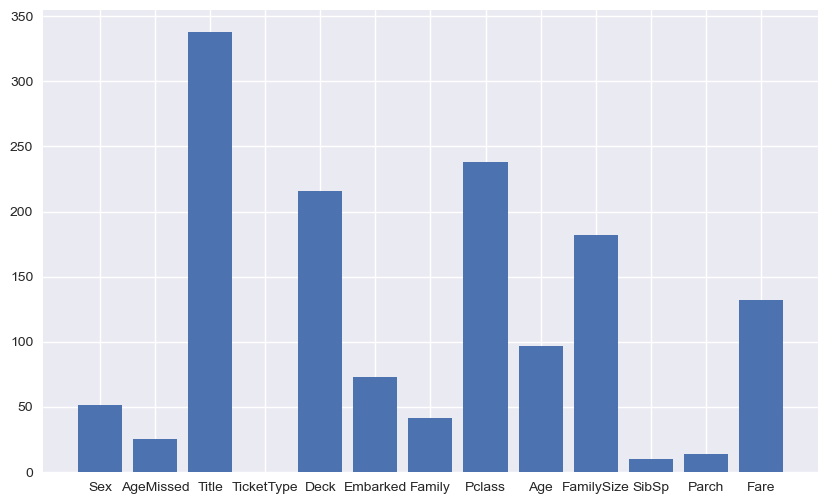

In [27]:
feature_reordered = cat_cols_wo_fam + ['Family'] + numer_cols

plt.bar(x=feature_reordered, height=bayes_search.best_estimator_['classifier'].feature_importances_)

In [28]:
model_type_list += ['All Columns']
model_list += [bayes_search.best_estimator_]
model_feature_list += [feature_reordered]
model_score_list += [bayes_search.best_score_]

## Feature Elimination by RFECV

In [29]:
rfecv_pipe = Pipeline(steps=[('impute', fillna_imputer),
                            ('transform', full_trans_fam), 
                            ('feature_selection', RFECV(estimator=lgbm_clf, step=1, cv=10, min_features_to_select=3))
                                ])

In [30]:
rfecv_pipe = Pipeline(steps=[('impute', fillna_imputer),
                            ('transform', full_trans_fam), 
                            ('feature_selection', RFECV(estimator=lgbm_clf, step=1, cv=10, min_features_to_select=3))
])

rfecv_params = {k.replace('classifier','feature_selection__estimator'): v for k,v in bayes_search.best_params_.items()}
rfecv_pipe = rfecv_pipe.set_params(**rfecv_params)

rfecv_pipe.fit(X_train_trans, y_train)
filtered_features = [i for (i, v) in zip(feature_reordered, rfecv_pipe[2].support_) if v]

In [31]:
print(f"Number of Features selected: {len(filtered_features)}")
print("Features:")
print(filtered_features)

Number of Features selected: 5
Features:
['Title', 'Deck', 'Pclass', 'FamilySize', 'Fare']


In [32]:
X_train_fe = X_train_trans[filtered_features]

numer_cols_fe = X_train_fe.select_dtypes(include='number').columns.to_list()
pipe_num_fe = StandardScaler(with_mean=False, with_std=False)  # a dummy transformer that did nothing on numeric data, use it to keep uneliminated numeric columns in the pipeline
cat_cols_wo_fam_fe = [x for x in X_train_fe.select_dtypes(exclude='number').columns.to_list() if x != 'Family']

transformer_list = [('numeric', pipe_num_fe, numer_cols_fe),
                    ('categoric', pipe_cat_wo_fam, cat_cols_wo_fam_fe)
                   ]
transformer_list += ('Family' in filtered_features) * [('family', pipe_fam, ['Family'])]
full_trans_fe = ColumnTransformer(transformers=transformer_list, remainder='drop')

In [33]:
transformer_list

[('numeric',
  StandardScaler(with_mean=False, with_std=False),
  ['Pclass', 'FamilySize', 'Fare']),
 ('categoric',
  Pipeline(steps=[('encoder', CountOrTargetEncoder(strategy='target')),
                  ('impute_after_encode',
                   WithinGroupImputer(num_fill_value=0,
                                      num_strategy='most_frequent'))]),
  ['Title', 'Deck'])]

In [34]:
full_pipe_fe = Pipeline(steps=[('impute', fillna_imputer),
                                ('transform', full_trans_fe), 
                                ('classifier', lgbm_clf)
                                ])

In [35]:
bayes_search_fe = BayesSearchCV(estimator=full_pipe_fe, search_spaces=params_space, n_iter=80, cv=kfold, scoring='accuracy')
bayes_search_fe = bayes_search_fe.fit(X_train_trans, y_train)

print_grid_result(bayes_search_fe)

Best Result:


,AVG_Score,Score_StdD,classifier__learning_rate,classifier__max_depth,classifier__n_estimators,classifier__num_leaves,classifier__reg_alpha,classifier__reg_lambda,impute__num_strategy,transform__categoric__encoder__strategy
54,0.83427,0.027379,0.006212,2,412,33,0.007145,0.000002,median,target
62,0.83427,0.027379,0.006000,2,470,27,0.049007,0.000001,median,target
68,0.83427,0.027379,0.007361,2,250,25,0.027403,0.066419,median,target
78,0.83427,0.027379,0.006000,2,250,25,0.100000,0.000001,median,target



All results:


,AVG_Score,Score_StdD,classifier__learning_rate,classifier__max_depth,classifier__n_estimators,classifier__num_leaves,classifier__reg_alpha,classifier__reg_lambda,impute__num_strategy,transform__categoric__encoder__strategy
0,0.821629,0.039899,0.023268,3,460,48,0.003624,0.000038,constant,target
1,0.825843,0.031280,0.006783,4,320,80,0.065055,0.000001,median,target
2,0.814607,0.028646,0.042267,2,291,90,0.000006,0.000665,constant,count
3,0.823034,0.032638,0.061018,1,623,95,0.000005,0.001177,constant,target
4,0.817416,0.026796,0.007434,4,448,31,0.000127,0.000268,constant,count
5,0.824438,0.034144,0.041009,2,327,53,0.000009,0.008857,constant,target
6,0.830056,0.036598,0.046811,4,627,97,0.000020,0.000004,median,target
7,0.811798,0.025591,0.010369,3,748,96,0.022814,0.000519,constant,count
8,0.828652,0.031656,0.025816,2,367,97,0.000033,0.000050,constant,target
9,0.811798,0.029595,0.101169,2,352,81,0.000701,0.033039,constant,count


In [36]:
model_type_list += ['Columns Selected by RFECV']
model_list += [bayes_search_fe.best_estimator_]
model_feature_list += [filtered_features]
model_score_list += [bayes_search_fe.best_score_]

# Picking Final Model and Check Testing Score

In [37]:
df_model = pd.DataFrame({'Model Type': model_type_list, 
                         'Model': model_list,
                         'Model Features': model_feature_list,
                         'Model Score': model_score_list
                         })

In [38]:
df_model.sort_values('Model Score', ascending=False,ignore_index=True, inplace=True)

df_model

,Model Type,Model,Model Features,Model Score
0,Columns Selected by RFECV,"(WithinGroupImputer(num_fill_value=999), Colum...","[Title, Deck, Pclass, FamilySize, Fare]",0.834270
1,All Columns,"(WithinGroupImputer(num_fill_value=999), Colum...","[Sex, AgeMissed, Title, TicketType, Deck, Emba...",0.830056


In [39]:
final_model = df_model['Model'][0]

In [40]:
joblib.dump(final_model, filename='Model/final_model.pkl', compress=1)

['Model/final_model.pkl']

In [41]:
final_model.fit(X_train_trans, y_train)

Pipeline(steps=[('impute', WithinGroupImputer(num_fill_value=999)),
                ('transform',
                 ColumnTransformer(transformers=[('numeric',
                                                  StandardScaler(with_mean=False,
                                                                 with_std=False),
                                                  ['Pclass', 'FamilySize',
                                                   'Fare']),
                                                 ('categoric',
                                                  Pipeline(steps=[('encoder',
                                                                   CountOrTargetEncoder(strategy='target')),
                                                                  ('impute_after_encode',
                                                                   WithinGroupImputer(num_fill_value=0,
                                                                                      num_strategy='most_frequent'))]),
                                                  ['Title', 'Deck'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.8, is_unbalance=True,
                                learning_rate=0.006212231668510311, max_depth=2,
                                n_estimators=412, num_leaves=33,
                                random_state=42,
                                reg_alpha=0.0071452388769375355,
                                reg_lambda=1.5411090992355673e-06,
                                subsample=0.8))])

In [42]:
test_pred = final_model.predict(X_test_trans)

In [43]:
print(f"Accuracy Score: {accuracy_score(y_test, test_pred)}")
print(f"F1 Score: {f1_score(y_test, test_pred)}")

Accuracy Score: 0.8212290502793296
F1 Score: 0.7894736842105263


In [44]:
confusion_matrix(y_test, test_pred)

array([[87, 18],
       [14, 60]])

In [45]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       105
           1       0.77      0.81      0.79        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179

